In [166]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from tqdm import tqdm_notebook
from keras.models import Model
from keras import backend as K
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
np.random.seed(0) # setting the seed in order to make it fixed

In [4]:
# Doing data related implementations
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [5]:
# Train and testing dataset which have been flattened
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


## Training the VAE

In [17]:
original_dimensions = x_train.shape[1]
hidden_layer_size = 512
batch_size = 128
latent_dim = 2
epochs = 75

In [7]:
# Input fed to the autoencoder is of the form of the batch size and the dimension of the image
inputs = Input(shape=(original_dimensions,), name='encoder_input')
h = Dense(hidden_layer_size, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='g_mean')(h)
z_log_sigma = Dense(latent_dim, name='g_variance')(h)

W0828 10:41:44.723735 140702627399488 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 10:41:44.771546 140702627399488 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 10:41:44.776605 140702627399488 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [9]:
def parametrization(args):
    # REPARAMETRIZATION TRICK
    m, v = args
    epsilon = tf.random.normal(shape=(2,))
    return m + K.exp(0.5 * v) * epsilon

In [10]:
# Get the combined z value from the function using the mean and sigma learnt by the autoencoder
z = Lambda(parametrization)([z_mean, z_log_sigma])

In [11]:
decoder_h = Dense(hidden_layer_size, activation='relu', name='decode_intermediate')
decoder_mean = Dense(original_dimensions, activation='sigmoid', name='decode_full')

In [12]:
# Same dimensions of the layers as the encoders but takes in the opposite way - as the autoencoder should
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)
# encoder, from inputs to latent space
encoder = Model(inputs, z)

In [14]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)
# end-to-end autoencoder - defining the input and output points
vae = Model(inputs, x_decoded_mean)

In [15]:
def total_loss(x, x_decoded_mean):
    rcons_loss = binary_crossentropy(x, x_decoded_mean)
    rcons_loss *= original_dimensions
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return rcons_loss + kl_loss

vae.compile(optimizer='adam', loss=total_loss)

W0828 10:47:08.212762 140702627399488 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0828 10:47:08.245944 140702627399488 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0828 10:47:08.253271 140702627399488 deprecation.py:323] From /home/harshdeep/accenture/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
x_decoded_mean.shape

TensorShape([Dimension(None), Dimension(784)])

In [18]:
# Fit the model to the data but labels and data would be the same since it is a generative model
# vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
vae.fit(x_train,x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, x_test))

W0828 10:47:34.231591 140702627399488 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/75
60000/60000 [==============================] - 13s 210us/step - loss: 197.7288 - val_loss: 171.5756
Epoch 2/75
60000/60000 [==============================] - 12s 201us/step - loss: 168.1374 - val_loss: 165.4440
Epoch 3/75
60000/60000 [==============================] - 13s 210us/step - loss: 163.3509 - val_loss: 161.8238
Epoch 4/75
60000/60000 [==============================] - 12s 208us/step - loss: 160.9151 - val_loss: 160.4372
Epoch 5/75
60000/60000 [==============================] - 12s 205us/step - loss: 159.2366 - val_loss: 158.7907
Epoch 6/75
60000/60000 [==============================] - 12s 200us/step - loss: 157.7600 - val_loss: 158.1651
Epoch 7/75
60000/60000 [==============================] - 13s 213us/step - loss: 156.4747 - val_loss: 156.4061
Epoch 8/75
60000/60000 [==============================] - 14s 230us/step - loss: 155.2016 - val_loss: 155.0709
Epoch 9/75
60000/60000 [==============================] - 11s 

Epoch 74/75
60000/60000 [==============================] - 9s 155us/step - loss: 140.9148 - val_loss: 146.8612
Epoch 75/75
60000/60000 [==============================] - 9s 153us/step - loss: 140.6896 - val_loss: 146.7519


In [19]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

In [20]:
# display a 2D manifold of the digits
n = 15  # number of digits to be generated
digit_size = 28 # Size of the digits
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        
        # Looking in the Z-sample space with the dimensions for x and y
        # 0.2 is basically trying to bound the set of items you can intake - so it is a parameter
        z_sample = np.array([[xi, yi]]) * 0.2
        # Put the values of the Z sample space in the decoder
        x_decoded = generator.predict(z_sample)
        # Reshape the digit into 28*28 - 2D thingy!
        digit = x_decoded[0].reshape(digit_size, digit_size)
        # Assign the digit into the output set 
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

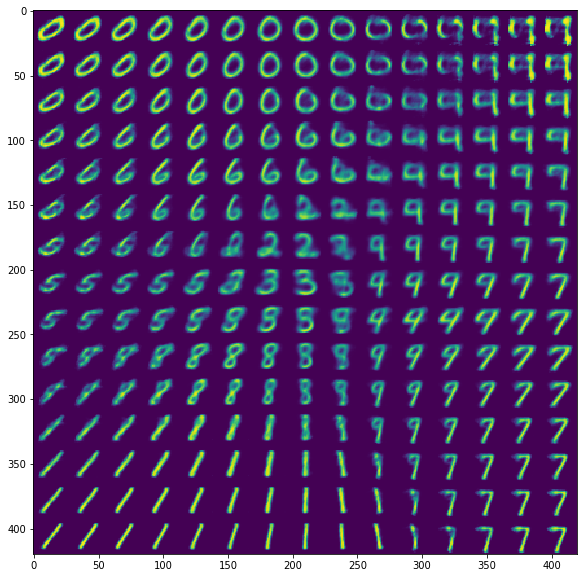

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

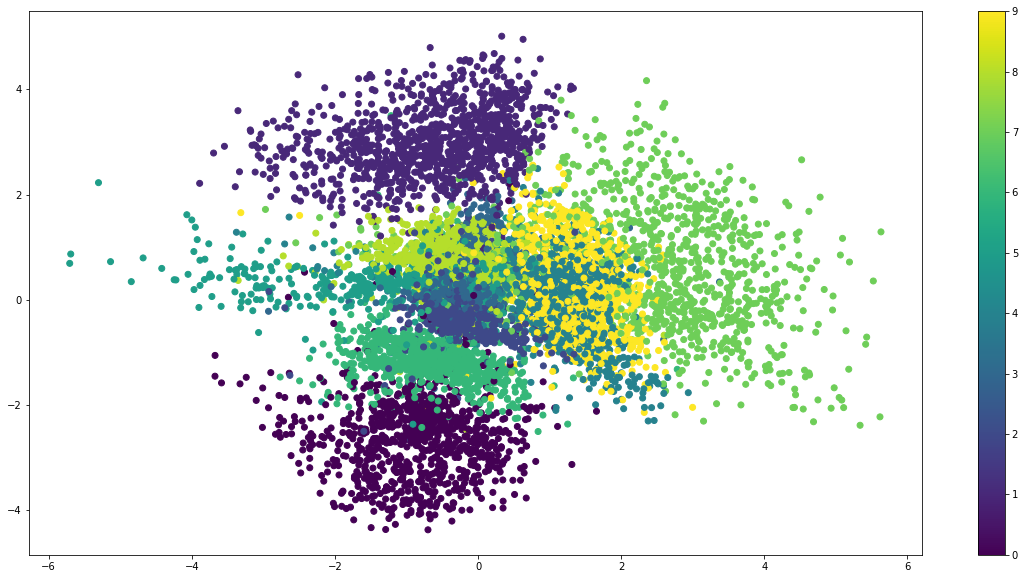

In [23]:
# Plotting the graph for consistency and looking where does each class belong
plt.figure(figsize=(20, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [194]:
import keras.backend as K
from sklearn.neighbors import NearestNeighbors

In [262]:
sess = tf.Session()

In [263]:
sess.run(tf.global_variables_initializer())

In [264]:
class RiemannianMetric():
    def __init__(self, decoder_input, decoder_output, sess):
        self.n_nodes = int(x_test_encoded.shape[0] / 10)
        self.decoder_output = decoder_output
        self.decoder_input = decoder_input
        self.sess = sess
        
    def get_riemannian_distance(self, z1, z2):
        n_steps = 5
        t = np.linspace(0, 1, n_steps)
        dt = t[1] - t[0]
        print('These are the points', z1, z2)
        # Get all the n_steps of equidistant points
        the_line = np.vstack([_ * z1 + (1 - _) * z2 for _ in t])
        G_eval = self.sess.run(self.G, feed_dict={self.decoder_input: the_line})
        # Calculating the observation space distance between 2 points in the space
        # @ operator is a shorthand for matrix multiplication
        L_discrete = np.sqrt((z1-z2) @ G_eval @ (z1-z2).T)
        L_discrete = L_discrete.flatten()
        distance = np.sum(dt * L_discrete)
        return distance
    
    def calculate_J_and_G_matrix(self):
        J = []
        print('Inside calculate J and G matrix')
        output_dim = self.decoder_output.shape[1]
        print('The output dim is: {}'.format(output_dim))
        # Finding the gradient of costs with respect to input
        J = [
            tf.gradients(self.decoder_output[:, _], self.decoder_input)[0] 
            for _ in tqdm_notebook(range(output_dim))
        ]
        print('The number of elements in J are: {}  {}'.format(len(J), J[0].eval(session=self.sess)))
        J = tf.stack(J, axis=1)
        print(J.shape)
        G = tf.transpose(J, [0, 2, 1]) @ J
        self.G = G
        self.J = J

class RiemannianTree(object):
    def __init__(self, latent, distance_metric):
        self.n_nodes = int(x_test_encoded.shape[0] / 10)
        self.distance_metric = distance_metric
        self.latent = latent
        
    def create_riemannian_graph(self, n_neighbors):
        """
        Makes a KD Tree by taking into the riemannian distance.
        """
        sampled_indices = np.random.randint(10000, size=(self.n_nodes,))
        sampled_nodes = self.latent[sampled_indices]
        
        # Make a KD-Tree and fit it to the sampled nodes and set the distances 
        neigh = NearestNeighbors(
            n_neighbors=n_neighbors,
            algorithm='ball_tree', leaf_size=10, metric=self.distance_metric.get_riemannian_distance)
        neigh.fit(sampled_nodes)

In [265]:
rmetric = RiemannianMetric(generator.input, generator.output, sess)

In [266]:
rmetric.calculate_J_and_G_matrix()

Inside calculate J and G matrix
The output dim is: 784


InvalidArgumentError: You must feed a value for placeholder tensor 'input_2' with dtype float and shape [?,2]
	 [[node input_2 (defined at /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517) ]]

Original stack trace for 'input_2':
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-bcff787badd1>", line 2, in <module>
    decoder_input = Input(shape=(latent_dim,))
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/keras/engine/input_layer.py", line 178, in Input
    input_tensor=tensor)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/keras/engine/input_layer.py", line 87, in __init__
    name=self.name)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 517, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 2143, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 6262, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/harshdeep/accenture/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [232]:
rtree = RiemannianTree(generator.input, generator.output, x_test_encoded, rmetric)

In [233]:
rtree.create_riemannian_graph(10)

These are the points [0.06097335 0.18213367] [ 2.2784102  -0.81755698]


AttributeError: 'RiemannianTree' object has no attribute 'G'